# Model Training

### Context

#### README: Context and Purpose 

Author: Alejandro Garay, 20250519, CABA, Argentina. #cs-analytics

This notebook documents the training of a placeholder model for the Privacy Case Classifier (PCC) pipeline. The goal is to create a first-stage filter that can reliably identify customer support cases that are likely to be privacy-related (PC), with an emphasis on **high recall** over precision.

The labeled dataset available was limited — and after embedding validation, only ~50% of it proved usable. This forced me to be surgical in how I built a training set. Instead of defaulting to brute-force oversampling, I took care to **mirror the semantic density and intent distribution** of the actual unlabeled corpus.

I selected a representative slice from July 2024:
- Stratified by intent proportions (matching real-world frequencies)
- Filtered by semantic density (cases with ~95 words per conversation, matching the PC-labeled set)
- Ensuring label balance with **SMOTE**, but only after curating the sample

The resulting dataset gave the model real signal on what both **is** and **is not** a privacy case — which is essential for boundary decisions in production. UMAP projections confirmed class separability in the embedding space, which explains the excellent performance of even a simple `LogisticRegression`.

This placeholder model isn't final — it’s a solid base for benchmarking, and serves as the first filter in a longer pipeline that will eventually route high-confidence PC cases to LLM-based subtype classifiers.

In [ ]:
pip install imblearn, umap-learn

ERROR: Invalid requirement: 'imblearn,'

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: /home/workbench/.pyenv/versions/workbench/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np 
import pandas as pd
from bqt import bqt

In [47]:
pd.set_option('display.max_columns', None)


In [ ]:
%%bqt raw_df
FROM `redacted`

Found cached data that is 18 hour(s) 37 minute(s) 35 second(s) old, using it.


,case_id,embedding_vector,translated_message,pcc
0,f39da2a6-818c-4e61-904c-9aa78735a831,"[-0.01763484813272953, -0.09179778397083282, 0...",Reset password email is not coming through Art...,0
1,70b2fa85-66d9-475c-9882-9f953f421374,"[-0.032968420535326004, -0.03022358939051628, ...",Accidentally forgot to cancel my subscription ...,0
2,daccce9b-c6bd-4d05-a03c-38e257a1129d,"[-0.007895362563431263, -0.039548806846141815,...",I got kicked off my plan. I tried confirming m...,0
3,02569b27-faef-417d-a238-c51dfeb2b65a,"[0.006483832374215126, -0.05447908490896225, 0...",I want to cancel the free Hulu immediately Del...,0
4,98d36440-c7b3-407f-b039-5b649a79bef6,"[0.028492191806435585, -0.03453421592712402, 0...",Refund the money was debited 2 days ago and I ...,0
5,7fdf9c68-87b1-4641-b161-ab3d39b3f619,"[0.02064083144068718, 0.05286814644932747, 0.0...","I want a refund for a plan, I put it as the in...",0
6,3e7e0172-11ed-406f-a6d9-a029c9bb0a6a,"[-0.01786004938185215, 0.02218823879957199, -0...",My plan charged 19.99 I want to stay with fami...,0
7,046f7662-8a31-4c0a-89c5-d11bc21385f7,"[-0.049773767590522766, -0.05637732148170471, ...",I want to change back to free plan Close my ac...,0
8,417900408,"[-0.01824222132563591, -0.07438769936561584, 0...",my email is erinwoohoohotmail.com I use my iph...,0
9,06541da9-644d-407d-a011-30fe4480aa3a,"[-0.0112229622900486, -0.038343772292137146, -...","Hello,Please cancel these Spotify subscription...",0


In [12]:
raw_df.columns

Index(['case_id', 'embedding_vector', 'translated_message', 'pcc'], dtype='object')

In [43]:
raw_df.dtypes

case_id               object
embedding_vector      object
translated_message    object
pcc                    int64
dtype: object

In [42]:
raw_df.shape

(1094, 4)

In [41]:
print(type(raw_df["embedding_vector"].iloc[0]))
print(raw_df["embedding_vector"].iloc[0].shape)
print(np.isnan(raw_df["embedding_vector"].iloc[0]).any())

<class 'numpy.ndarray'>
(384,)
False


In [74]:
from preprocessing.embed_text import validate_embeddings
df = validate_embeddings(raw_df, debug=True)

[27] Dropped: bad shape (0,)
[496] Dropped: bad shape (0,)
[519] Dropped: bad shape (0,)
[547] Dropped: bad shape (0,)
[548] Dropped: bad shape (0,)
[550] Dropped: bad shape (0,)
[551] Dropped: bad shape (0,)
[552] Dropped: bad shape (0,)
[556] Dropped: bad shape (0,)
[557] Dropped: bad shape (0,)
[558] Dropped: bad shape (0,)
[561] Dropped: bad shape (0,)
[562] Dropped: bad shape (0,)
[565] Dropped: bad shape (0,)
[567] Dropped: bad shape (0,)
[568] Dropped: bad shape (0,)
[577] Dropped: bad shape (0,)
[579] Dropped: bad shape (0,)
[580] Dropped: bad shape (0,)
[581] Dropped: bad shape (0,)
[582] Dropped: bad shape (0,)
[585] Dropped: bad shape (0,)
[589] Dropped: bad shape (0,)
[590] Dropped: bad shape (0,)
[591] Dropped: bad shape (0,)
[592] Dropped: bad shape (0,)
[595] Dropped: bad shape (0,)
[596] Dropped: bad shape (0,)
[597] Dropped: bad shape (0,)
[600] Dropped: bad shape (0,)
[603] Dropped: bad shape (0,)
[604] Dropped: bad shape (0,)
[605] Dropped: bad shape (0,)
[607] Dropp

Used a placeholder function instead of production embed_text.py to debug training dataset

In [75]:
df.shape

(758, 4)

### Training Set

pcc
0    544
1    214
Name: count, dtype: int64


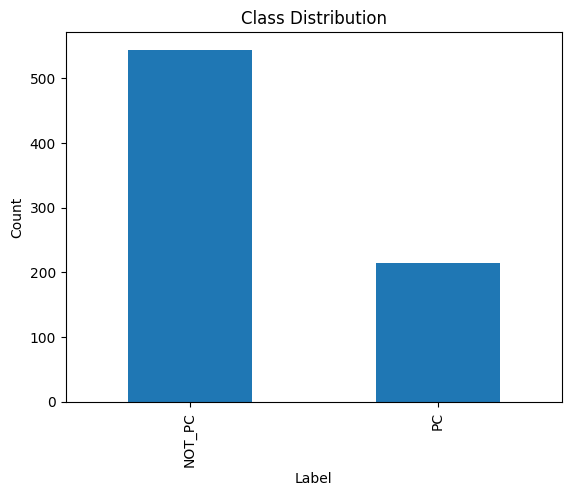

In [76]:
import pandas as pd

# Check value counts
print(df["pcc"].value_counts())

# Optional: plot
import matplotlib.pyplot as plt

df["pcc"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xticks(ticks=[0,1], labels=["NOT_PC", "PC"])
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

After validation, we're left with an unbalanced dataset with few pc cases left. This has always been the main challenge of the project, the lack of labeled data. 

In [79]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Prepare X and y
X = np.stack(df["embedding_vector"].values)
y = df["pcc"].values

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

print(f"After SMOTE: {np.bincount(y_resampled)}")

After SMOTE: [544 544]


We use SMOTE to balance the training set and bing it to 1:1

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled  # Keep class balance
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (870, 384)
Test shape: (218, 384)


/home/workbench/.pyenv/versions/workbench/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


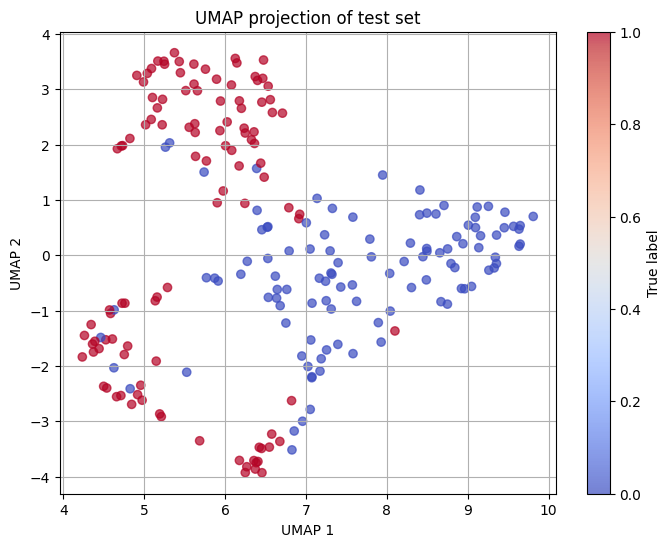

In [101]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_test)

plt.figure(figsize=(8,6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_test, cmap="coolwarm", alpha=0.7)
plt.title("UMAP projection of test set")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.colorbar(label="True label")
plt.show()

We see a good segregation or separation of calses

### Training and Tuning

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Definimos el modelo base
logreg = LogisticRegression(max_iter=1000, solver='liblinear')

# Hiperparámetros a explorar
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"]
}

# Grid Search con validación cruzada (5 folds)
clf = GridSearchCV(logreg, param_grid, cv=5, scoring="f1", verbose=1)
clf.fit(X_train, y_train)

# Mejor modelo
best_model = clf.best_estimator_
print("Best Params:", clf.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Best Params: {'C': 10, 'penalty': 'l1'}


              precision    recall  f1-score   support

      NOT_PC       0.95      0.99      0.97       109
          PC       0.99      0.94      0.97       109

    accuracy                           0.97       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.97      0.97      0.97       218



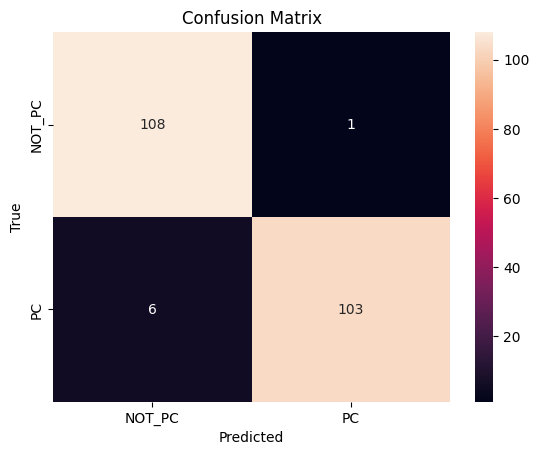

In [84]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["NOT_PC", "PC"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["NOT_PC", "PC"], yticklabels=["NOT_PC", "PC"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Model Evaluation

ROC AUC: 0.9980641360154868


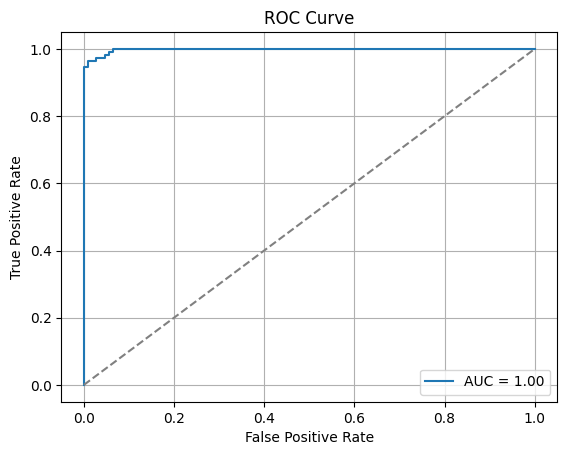

In [85]:
from sklearn.metrics import roc_auc_score, roc_curve

y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

PR AUC: 0.9981191334928606


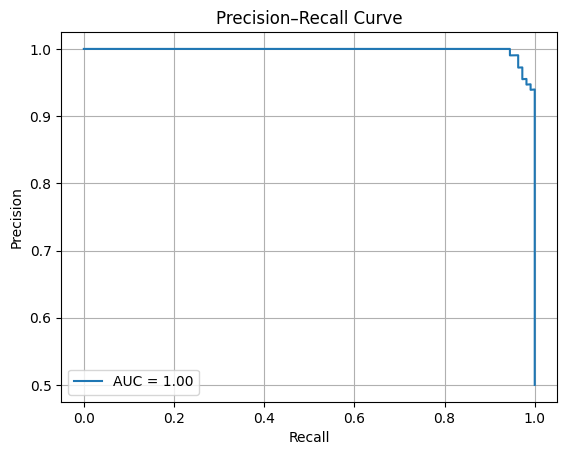

In [86]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

plt.plot(recall, precision, label=f"AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

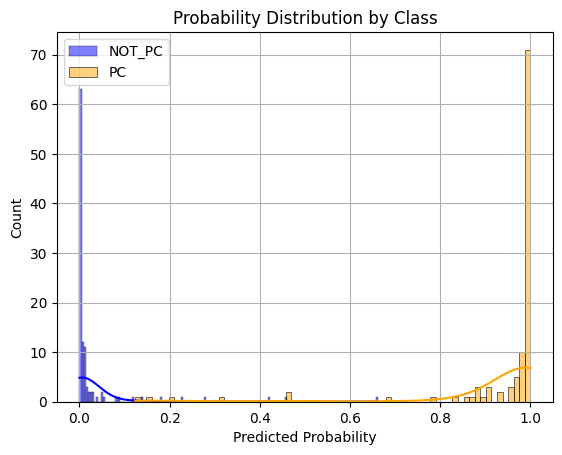

In [87]:
import seaborn as sns

sns.histplot(y_proba[y_test == 0], label="NOT_PC", color="blue", kde=True)
sns.histplot(y_proba[y_test == 1], label="PC", color="orange", kde=True)
plt.xlabel("Predicted Probability")
plt.title("Probability Distribution by Class")
plt.legend()
plt.grid(True)
plt.show()

### Save Model Pkl

In [ ]:
import joblib
import json
import os
from datetime import datetime

os.makedirs("src/models", exist_ok=True)

joblib.dump(best_model, "src/models/pcc_v0.1.1.pkl")

metadata = {
    "model_version": "v0.1",
    "trained_on": datetime.now().strftime("%Y-%m-%d"),
    "embedding_model": "all-MiniLM-L6-v2",
    "label_mapping": {"NOT_PC": 0, "PC": 1},
    "train_shape": X_train.shape,
    "classifier": "LogisticRegression",
    "config": {
        "solver": best_model.solver,
        "penalty": best_model.penalty,
        "C": best_model.C
    },
    "notes": "MVP placeholder model trained on SMOTE-balanced MiniLM embeddings."
}

os.makedirs("models", exist_ok=True)
with open("models/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("Model and metadata saved.")

Model and metadata saved.
